In [8]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import os.path as osp

import torch
from torch_geometric.data import Dataset, download_url, InMemoryDataset
from torch_geometric.io import fs

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, summary
import torch.optim as optim
from pgmpy.models import BayesianNetwork, BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, ExpectationMaximization
from pgmpy.inference import VariableElimination

In [2]:
# Data dictionary
tree = {
    'aT': 0.64277,
    'aF': 0.35723,
    'pT': 0.32997,
    'pF': 0.67003,
    'gT': 0.15953,
    'gF': 0.84047,
    'bT': 0.5,
    'bF': 0.5,
    'rT': 0.32841,
    'rF': 0.67159,
    
    'sT': {
        'pFaF': 0.43118, 'pTaF': 0.74591, 'pFaT': 0.8686, 'pTaT': 0.91576,  
    },
    'sF': {
        'pFaF': 1-0.43118, 'pTaF': 1-0.74591, 'pFaT': 1-0.8686, 'pTaT': 1-0.91576
    },
    'yfT': {
        'sF': 0.23119, 'sT': 0.95372
    },
    'yfF': {
        'sF': 1-0.23119, 'sT': 1-0.95372
    },
    'lcT': {
        'gFsF': 0.23146, 'gTsF': 0.86996, 'gFsT': 0.83934, 'gTsT': 0.99351
    },   
    'lcF': {
        'gFsF': 1-0.23146, 'gTsF': 1-0.86996, 'gFsT': 1-0.83934, 'gTsT': 1-0.99351
    },
    'adT': {
        'gF': 0.28956, 'gT': 0.68706
    },
    'adF': {
        'gF': 1-0.28956, 'gT': 1-0.68706
    },
    'cT': {
        'alFlcF': 0.1347, 'alTlcF': 0.64592, 'alFlcT': 0.7664, 'alTlcT': 0.99947
    },
    'cF': {
        'alFlcF': 1-0.1347, 'alTlcF': 1-0.64592, 'alFlcT': 1-0.7664, 'alTlcT': 1-0.99947
    },
    'fT': {
        'lcFcF': 0.35212, 'lcTcF': 0.56514, 'lcFcT': 0.80016, 'lcTcT': 0.89589
    },
    'fF': {
        'lcFcF': 1-0.35212, 'lcTcF': 1-0.56514, 'lcFcT': 1-0.80016, 'lcTcT': 1-0.89589
    },
    'caT': {
        'adFfF': 0.2274, 'adTfF': 0.779, 'adFfT': 0.78861, 'adTfT': 0.97169
    },
    'caF': {
        'adFfF': 1-0.2274, 'adTfF': 1-0.779, 'adFfT': 1-0.78861, 'adTfT': 1-0.97169
    }
}

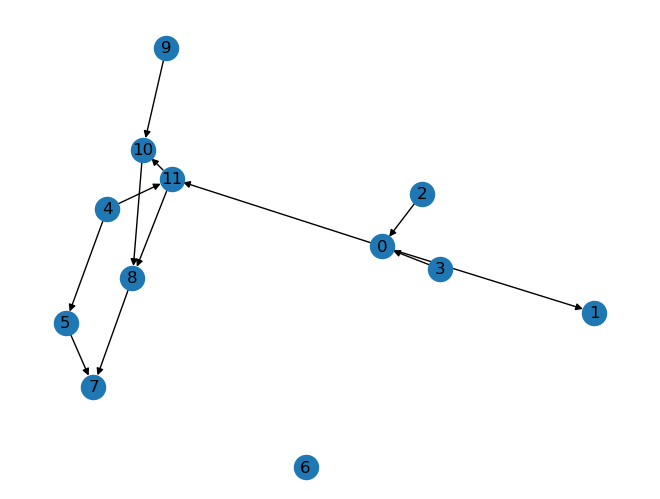

In [3]:
class LUCAS0Dataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(LUCAS0Dataset, self).__init__(root, transform, pre_transform)
        self.data = fs.torch_load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['lucas0_train.csv']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        # Download to `self.raw_dir`.
        download_url('https://www.causality.inf.ethz.ch/data/lucas0_train.csv', self.raw_dir)

    def process(self):
        print(self.processed_paths)
        # Load in the data
        self.data = pd.read_csv(self.raw_paths[0])
        
        # Get the node features
        self._get_node_features()
        
        # Get the edge index
        self._get_edge_index()
    
        # Get the labels
        self._get_labels()
        
        # Save the data
        data = Data(x=self.X, edge_index=self.edge_index, y=self.y)
        
        # Save the data
        torch.save(data, osp.join(self.processed_dir, 'data.pt'))
        
        
    def _get_node_features(self):
        self.X = torch.tensor(self.data.values, dtype=torch.float).t()
        
    
    def _get_edge_index(self):
        from_list = [2, 3, 0, 0 , 4 , 4, 5, 11, 11, 9 , 10, 8]
        to_list   = [0, 0, 1, 11, 11, 5, 7, 10, 8 , 10, 8 , 7]
        self.edges = [(i, j) for i, j in zip(from_list, to_list)]  # Connect all nodes
        self.edge_index = torch.tensor(self.edges, dtype=torch.long).t().contiguous()
    
    
    def _get_labels(self):
        self.y = torch.tensor(self.data.Lung_cancer.values, dtype=torch.float)        


    def len(self):
        return len(self.processed_file_names)

dataset = LUCAS0Dataset(root='data/')[0]

# Visualize the graph
G = to_networkx(dataset)
nx.draw(G, with_labels=True)
plt.show()

In [4]:
df = pd.read_csv('data/raw/lucas0_train.csv')
df

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


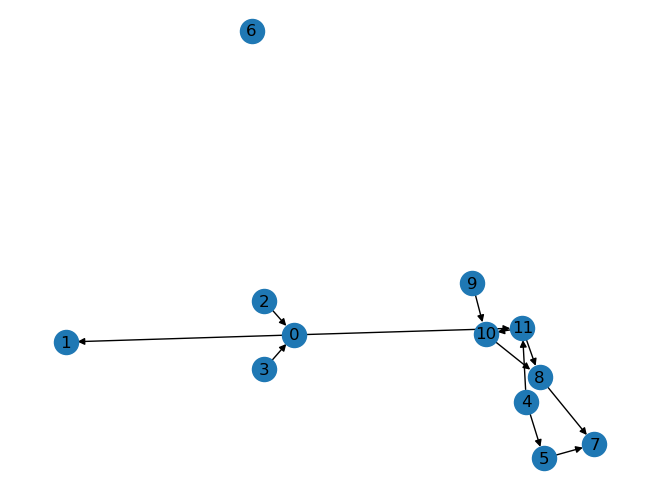

In [5]:
# Your tabular data excluding the target
tabular_data = df.values[:,:-1]
split = int(tabular_data.shape[0] * 0.8)

from_list = [2, 3, 0, 0, 4, 4, 5, 11, 11, 9, 10, 8]
to_list   = [0, 0, 1, 11, 11, 5, 7, 10, 8, 10, 8, 7]

# Create graph data
edges = [(i, j) for i, j in zip(from_list, to_list)]  # Connect all nodes
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Node features with train and test split
x_train = torch.tensor(tabular_data[:split], dtype=torch.float).t()
x_test = torch.tensor(tabular_data[split:], dtype=torch.float).t()
y_train = torch.tensor(df.Lung_cancer.values[:split], dtype=torch.float)
y_test = torch.tensor(df.Lung_cancer.values[split:], dtype=torch.float)
x = torch.tensor(tabular_data, dtype=torch.float).t()
y = torch.tensor(df.Lung_cancer.values, dtype=torch.float)

# Assuming there are no node labels or edge features in this example
train_data = Data(x=x_train, edge_index=edge_index, y=y_train)
test_data = Data(x=x_test, edge_index=edge_index, y=y_test)
data = Data(x=x, edge_index=edge_index, y=y)

# Plot the data using networkx
G = to_networkx(data)
nx.draw(G, with_labels=True)

In [7]:
print(df)

      Smoking  Yellow_Fingers  Anxiety  Peer_Pressure  Genetics  \
0           0               0        1              0         0   
1           0               1        0              0         0   
2           1               1        1              0         1   
3           0               0        0              1         0   
4           1               1        1              0         0   
...       ...             ...      ...            ...       ...   
1995        0               0        1              0         0   
1996        1               1        1              0         0   
1997        1               1        0              1         0   
1998        1               1        1              0         1   
1999        1               1        0              1         0   

      Attention_Disorder  Born_an_Even_Day  Car_Accident  Fatigue  Allergy  \
0                      1                 0             1        0        1   
1                      0               

In [11]:
# split the df into train and test
split = int(df.shape[0] * 0.8)
train_df = df.iloc[:split]
test_df = df.iloc[split:]

In [9]:
for col in df.columns:
    print(f'{col}: {df[col].unique()}')

Smoking: [0 1]
Yellow_Fingers: [0 1]
Anxiety: [1 0]
Peer_Pressure: [0 1]
Genetics: [0 1]
Attention_Disorder: [1 0]
Born_an_Even_Day: [0 1]
Car_Accident: [1 0]
Fatigue: [0 1]
Allergy: [1 0]
Coughing: [0 1]
Lung_cancer: [0 1]


In [32]:
model_dict = [('Anxiety', 'Smoking'), ('Peer_Pressure', 'Smoking')]
model_dict.extend([('Smoking', 'Yellow_Fingers'), ('Smoking', 'Lung_cancer')])
model_dict.extend([('Genetics', 'Lung_cancer'), ('Genetics', 'Attention_Disorder')])
model_dict.extend([('Lung_cancer', 'Coughing'), ('Lung_cancer', 'Fatigue')])
model_dict.extend([('Fatigue', 'Car_Accident'), ('Attention_Disorder', 'Car_Accident')])
model_dict.extend([('Allergy', 'Coughing'), ('Coughing', 'Fatigue')])

# Define the structure of the Bayesian network
model = BayesianNetwork(model_dict)

# Learn the parameters of the Bayesian network using Maximum Likelihood Estimation
model.fit(train_df, estimator=MaximumLikelihoodEstimator)

In [33]:
# Perform inference
infer = VariableElimination(model)

# Predict the target for each line of evidence
predictions = []

for i in range(test_df.shape[0]):
    evidence = test_df.iloc[i].to_dict()
    evidence = {k: v for k, v in evidence.items() if k not in  ('Lung_cancer', 'Born_an_Even_Day')}
    query = infer.query(variables=['Lung_cancer'], evidence=evidence)
    predictions.append(query.values.argmax())

# Calculate the accuracy
accuracy = sum(predictions == test_df.Lung_cancer) / test_df.shape[0]

print(f'Accuracy: {accuracy}')

Accuracy: 0.8625
